In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from random import *
from matplotlib import pyplot as plt
import numpy as np
import GPy
from datetime import datetime

# change here
model_class_names = [3]

lightcurve_test_set_path = "./StarLightCurves/StarLightCurves_TEST"

In [7]:
X_file_path = "./hpc_result/files/X_files/X_" + str(model_class_names)  + ".npy"
Y_file_path = "./hpc_result/files/Y_files/Y_" + str(model_class_names)  + ".npy"
model_path = "./hpc_result/files/model_save_files/model_save" + str(model_class_names) + ".npy"

In [8]:
# X_file_path = "./StarLight_files/X_files/X_" + str(model_class_names)  + ".npy"
# Y_file_path = "./StarLight_files/Y_files/Y_" + str(model_class_names)  + ".npy"
# model_path = "./StarLight_files/model_save_files/model_save" + str(model_class_names) + ".npy"

# X_file_path = "./sample_size_train_code/light_curve_model_files/X_[1, 3]0.08.npy"
# Y_file_path = "./sample_size_train_code/light_curve_model_files/Y_[1, 3]0.08.npy"
# model_path = "./sample_size_train_code/light_curve_model_files/model_save[1, 3]0.08.npy"

X_load = np.load(X_file_path)
Y_load = np.load(Y_file_path)


kern_class = GPy.kern.Matern32(input_dim=1, variance=1.5, lengthscale=2.5, active_dims=[0], name='class')
kern_replicate = GPy.kern.Matern32(input_dim=1, variance=.1, lengthscale=2.5, active_dims=[0], name='replicate')
k_hierarchy = GPy.kern.Hierarchical(kernels=[kern_class, kern_replicate])

In [9]:
m_load = GPy.models.GPRegression(X_load, Y_load, initialize=False, kernel=k_hierarchy)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(model_path) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)

 C:\Users\capec\Anaconda3\lib\site-packages\paramz\parameterized.py:57: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



Name : GP regression
Objective : -38368.42987188098
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                   |              value  |  constraints  |  priors
  hierarchy.class.variance         |     0.284317561682  |      +ve      |        
  hierarchy.class.lengthscale      |      10.8636726265  |      +ve      |        
  hierarchy.replicate.variance     |     0.392800027894  |      +ve      |        
  hierarchy.replicate.lengthscale  |      154.201135549  |      +ve      |        
  Gaussian_noise.variance          |  8.17239568272e-99  |      +ve      |        


 C:\Users\capec\Anaconda3\lib\site-packages\GPy\plotting\gpy_plot\plot_util.py:341: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


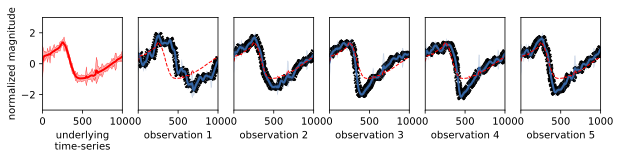

In [5]:

plt.figure(figsize=(10,1.98))
#to plot the mean function g_n(t), predict using only the 'kern_class' kernel

Xplot = np.linspace(1,1025, 100)[:,None]
mu, var = m_load.predict(Xplot, kern=kern_class)
ax = plt.subplot(1,6,1)
GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
plt.ylabel('normalized magnitude')
plt.xlabel('underlying\ntime-series')

#plot each of the functions f_{nr}(t)
for r in range(1,6):
    ax = plt.subplot(1,6,r+1)
    m_load.plot(fixed_inputs=[(1,r)],ax=ax, which_data_rows=X_load[:,1]==r, legend=False)
#     plt.plot(X_load[X_load[:,1]==r,0], Y_load[X_load[:,1]==r])
    plt.xlabel('observation %i'%r)
    plt.plot(Xplot, mu, 'r--', linewidth=1)

    
GPy.plotting.matplot_dep.base_plots.align_subplots(1,6, xlim=(1,1000), ylim=(-3,3))

# fig_name = 'result' + datetime.now().strftime("%Y-%m-%d %H-%M") + '.png'
fig_name = "./test_result/model_class_name_" + str(model_class_names)+'.png';

plt.subplots_adjust(bottom=0.3, top=0.95)

plt.savefig(fig_name, format='png', dpi=500);


In [6]:
class_names_test = np.loadtxt(lightcurve_test_set_path, delimiter=',', usecols=[0])

light_curve_test = np.loadtxt(lightcurve_test_set_path, delimiter=',', usecols=range(1, 1025))
light_curve_test -= light_curve_test.mean(1)[:,np.newaxis]
light_curve_test /= light_curve_test.std(1)[:,np.newaxis]


In [7]:
from scipy.interpolate import interp1d
def plot_test(sort_indeies, type, test_class_name, sort_value):
    plt.figure(figsize=(10,1.85))
    Xplot = np.linspace(1,1025, 100)[:,None]
    mu, var = m_load.predict(Xplot, kern=kern_class)
    ax = plt.subplot(1,6,1)
    GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
    plt.ylabel('normalized magnitude')
    plt.xlabel('underlying\nfunction')

    # X_r = np.arange(1,1025)
    # Y_r = light_curve_test[test_indices[0],:]

    # print(X_r.shape, Y_r.shape)

    for index, item in enumerate(sort_indeies):

        X_r = np.arange(1,1025)
        Y_r = light_curve_test[int(item),:]

        smooth_func = interp1d(X_r, Y_r, kind='cubic')
        # Xnew = np.linspace(X_r.min(), X_r.max(), num=sample_time_index_num, endpoint=True)
        plt.subplot(1, 6, index+2)
        plt.plot(X_r, Y_r, mew=2)
        # plt.plot(Xnew, smooth_func(Xnew), '-')
        plt.xlabel('star%i \n(%.2f)'%(item,sort_value[index]))
        plt.plot(Xplot, mu, 'r--', linewidth=1)
    
    GPy.plotting.matplot_dep.base_plots.align_subplots(1,6, xlim=(1,1000), ylim=(-3,3))
    fig_name = "./test_result/model_class_name_" + str(model_class_names) +"-test_class-" + str(test_class_name) + "_" + type+'.png';
    plt.subplots_adjust(bottom=0.3, top=0.95)
    plt.savefig(fig_name, format='png', dpi=500);
    

In [8]:
print(class_names_test.shape)

(8236,)


(1177, 2)
[ 2808.  7429.  7790.  8181.  2094.] 
 [-66.54319252 -66.5819239  -67.92783164 -74.12662106 -93.16105853]
[ 5282.  4696.  2091.  1038.  4448.] 
 [-3.48007646 -3.51184521 -3.55460194 -3.58459455 -3.65794253]
(2305, 2)
[ 3148.  2890.  2318.  6391.  4041.] 
 [-68.14189364 -68.7638846  -69.02326772 -70.95364401 -76.07709214]
[ 3495.  6111.  3959.   448.  7838.] 
 [-18.21619541 -19.97047646 -20.28191296 -21.88842123 -22.21246701]
(4754, 2)
[  332.  7567.  5960.  4710.  1372.] 
 [-80.36333602 -80.94156658 -81.97949707 -84.87602692 -94.63112523]
[ 1154.  2192.  1655.  4933.  3488.] 
 [-3.23967859 -3.23975563 -3.31937733 -3.31998303 -3.32578093]


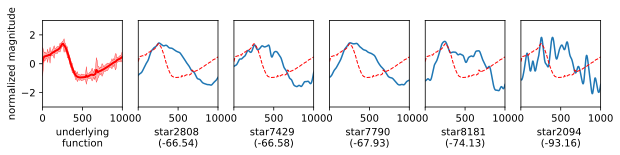

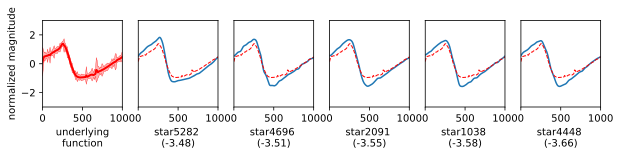

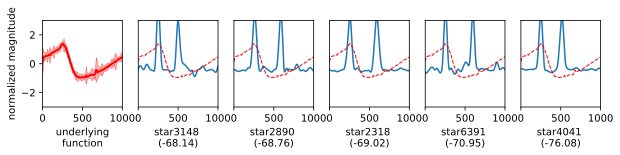

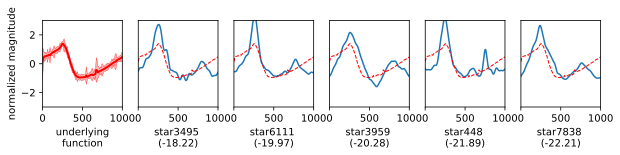

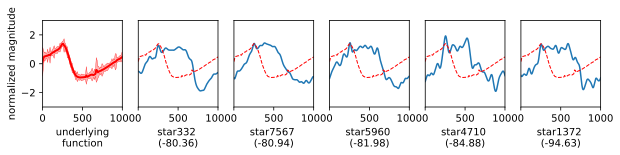

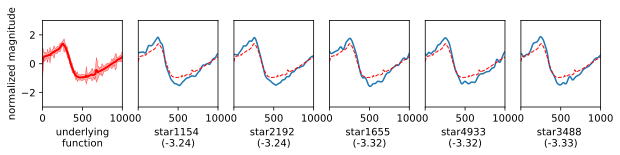

In [9]:
for test_model_class in range(1,4):
    test_indices = [i for i,cn in enumerate(class_names_test) if cn == test_model_class]
    log_pre_density_result = np.ones(len(test_indices)) * 9999
    log_pre_density_result = log_pre_density_result.reshape(-1,1)
    x_test = np.arange(1,1025)[:,None]
    mu_star, var_star = m_load.predict_noiseless(x_test, kern=kern_class) # read the source code for log_predictive
    for index in range(len(test_indices)):
        y_test = light_curve_test[test_indices[index],:].reshape(-1,1)
        log_pre_density_result[index] = np.average(m_load.likelihood.log_predictive_density(y_test, mu_star, var_star))
    
    test_indices = np.asarray(test_indices)
    test_indices = test_indices.reshape(-1,1)

    combine_result = np.concatenate((test_indices, log_pre_density_result), axis=1)
    sorted_result = np.sort(combine_result.view('i8,i8'), order=['f1'], axis=0).view(np.float)
    print(sorted_result.shape)
    
    result_file_name = "./test_result/sorted_result_model-" + str(model_class_names) + "class-" + str(test_model_class) + ".csv";
    np.savetxt(result_file_name, sorted_result, delimiter=",",fmt='%d,%1.9f')
    
    test_sort_last_indices = sorted_result[-5:][:,0]
    test_sort_last_value = sorted_result[-5:][:,1]
    print(test_sort_last_indices, '\n',test_sort_last_value)
    plot_test(test_sort_last_indices,"last",test_model_class, test_sort_last_value)
    
    test_sort_top_indices = sorted_result[:5:][:,0]
    test_sort_top_value = sorted_result[:5:][:,1]
    print(test_sort_top_indices,'\n',test_sort_top_value)
    plot_test(test_sort_top_indices, "top",test_model_class,test_sort_top_value)